In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from fancyimpute import IterativeImputer, KNN
import seaborn as sns

# Data preparation for linear model and machine learning model
## Step 1: Merge all data sets
The available data sets are:
- `train.csv`: contains bakery sales plus their IDs from 01-July 2013 to 31-July 2018
- `test.csv`: contains IDs for sales from 01-August 2018 to 30-July 2019
- `wetter.csv`: contains weather data
- `kiwo.csv`: contains Kieler Woche dates

Our additional data sets are:
- `wettercodes_one_hot.csv`: contains one-hot encoded weathercodes
- `Feiertage.csv`: contains national holidays in Schleswig-Holstein

In [166]:
# read train data set (our train and validation data)
df_train = pd.read_csv("../Data/bakery-sales-prediction-winter-2024-25/train.csv", parse_dates=['Datum'])

# read additional test data set
df_test = pd.read_csv("../Data/bakery-sales-prediction-winter-2024-25/test.csv", parse_dates=['Datum'])

# merge df_train and df_test
df_train_test = pd.concat([df_train, df_test])
df_train_test.sort_values("Datum")


,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
3638,1307013,2013-07-01,3,201.198426
5457,1307014,2013-07-01,4,65.890169
7223,1307015,2013-07-01,5,317.475875
1819,1307012,2013-07-01,2,535.856285
...,...,...,...,...
354,1907301,2019-07-30,1,NaN
709,1907302,2019-07-30,2,NaN
1773,1907305,2019-07-30,5,NaN
1418,1907304,2019-07-30,4,NaN


In [167]:
# Implement Kieler Woche data
kieler_woche_data = pd.read_csv('/workspaces/Bakery-Project/0_DataPreparation/Data/kiwo.csv')

# Convert the 'Datum' column to datetime for consistency
kieler_woche_data['Datum'] = pd.to_datetime(kieler_woche_data['Datum'])

# Merge Kieler Woche data with main DataFrame
df_train_test = df_train_test.merge(kieler_woche_data, on='Datum', how='left', suffixes=(False, False))

# set dates outside Kieler Woche to 0
df_train_test["KielerWoche"] = df_train_test["KielerWoche"].fillna(0)

df_train_test

,id,Datum,Warengruppe,Umsatz,KielerWoche
0,1307011,2013-07-01,1,148.828353,0.0
1,1307021,2013-07-02,1,159.793757,0.0
2,1307031,2013-07-03,1,111.885594,0.0
3,1307041,2013-07-04,1,168.864941,0.0
4,1307051,2013-07-05,1,171.280754,0.0
...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,0.0
11160,1812236,2018-12-23,6,NaN,0.0
11161,1812246,2018-12-24,6,NaN,0.0
11162,1812276,2018-12-27,6,NaN,0.0


In [168]:
# read wetter.csv
df_wetter = pd.read_csv("../Data/bakery-sales-prediction-winter-2024-25/wetter.csv", parse_dates=['Datum'])

# add wettercodes to the weather data frame
df_wettercodes = pd.read_csv("../Data/wettercodes_one_hot.csv", sep = ';')
df_wetter = df_wetter.merge(df_wettercodes, on = "Wettercode", how = "left", suffixes=(False, False))

# merge all weather data with the sales data
df_train_test = df_train_test.merge(df_wetter, on = "Datum", how = "left")
df_train_test = df_train_test.drop(columns = "Wettercode")
df_train_test.sort_values("Datum")

,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel
0,1307011,2013-07-01,1,148.828353,0.0,6.0,17.8375,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3638,1307013,2013-07-01,3,201.198426,0.0,6.0,17.8375,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5457,1307014,2013-07-01,4,65.890169,0.0,6.0,17.8375,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7223,1307015,2013-07-01,5,317.475875,0.0,6.0,17.8375,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1819,1307012,2013-07-01,2,535.856285,0.0,6.0,17.8375,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9688,1907301,2019-07-30,1,NaN,0.0,7.0,20.7375,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10043,1907302,2019-07-30,2,NaN,0.0,7.0,20.7375,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11107,1907305,2019-07-30,5,NaN,0.0,7.0,20.7375,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10752,1907304,2019-07-30,4,NaN,0.0,7.0,20.7375,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [169]:
# Add Feiertage.csv. 
# Holidays are implemented in the training data by adding a column that distinguishes between holidays or weekends and weekdays.

# Read Feiertage.csv
df_feiertage = pd.read_csv('../Data/Feiertage.csv', sep=';', parse_dates=['Datum'])
df_feiertage['Datum'] = pd.to_datetime(df_feiertage['Datum'])

# create holiday set
feiertage_set = set(df_feiertage['Datum'].dt.date)

# find weekend
def is_weekend(date):
    return date.weekday() == 6 or date.weekday() == 5

# code weekends and holidays
def is_holiday_or_weekend(date):
    return is_weekend(date) or date.date() in feiertage_set

# new column sun- or holiday
df_train_test['weekend_or_holiday'] = df_train_test['Datum'].apply(is_holiday_or_weekend).astype(int)

df_train_test

,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,weekend_or_holiday
0,1307011,2013-07-01,1,148.828353,0.0,6.0,17.8375,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1307021,2013-07-02,1,159.793757,0.0,3.0,17.3125,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1307031,2013-07-03,1,111.885594,0.0,7.0,21.0750,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,1307041,2013-07-04,1,168.864941,0.0,7.0,18.8500,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,1307051,2013-07-05,1,171.280754,0.0,5.0,19.9750,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,0.0,8.0,4.3000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11160,1812236,2018-12-23,6,NaN,0.0,7.0,6.4500,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
11161,1812246,2018-12-24,6,NaN,0.0,7.0,2.5000,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
11162,1812276,2018-12-27,6,NaN,0.0,7.0,7.1250,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


## Step 2: Dealing with missing values
- missing values in temperature, cloudiness, wind speed and weather code: solved by linear interpolation between previous and following day
- missing values in weather data imputed by KNN using k = 10

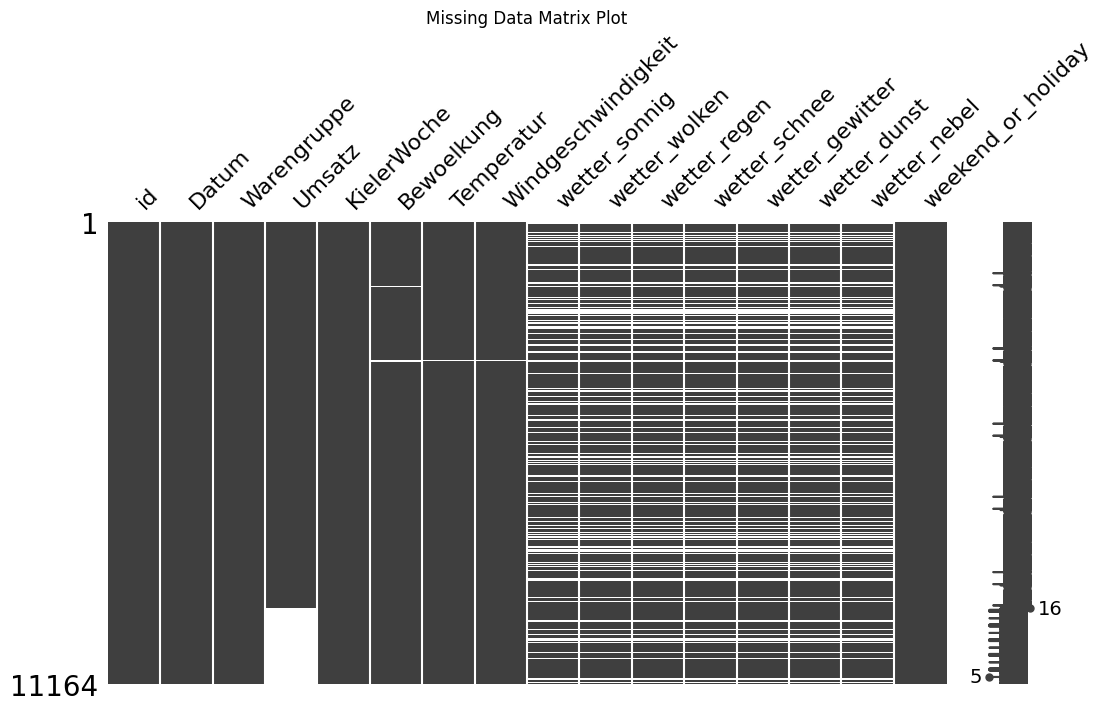

In [170]:
# Matrix plot of missing data
msno.matrix(df_train_test, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

In [171]:
# interpolate temperature, cloudiness, wind speed
df_train_test[["Temperatur", "Bewoelkung", "Windgeschwindigkeit"]] = df_train_test[["Temperatur", "Bewoelkung", "Windgeschwindigkeit"]].interpolate(method = "linear")

In [172]:
# convert date to float
#df_train_test["Datum"] = df_train_test[('Datum')].values.astype("float64")
columns = ["id", "wetter_sonnig", "wetter_wolken", "wetter_regen", "wetter_schnee", "wetter_gewitter", "wetter_dunst", "wetter_nebel"]
imputer_knn = KNN(k = 10)
df_train_test_knn = pd.DataFrame(imputer_knn.fit_transform(df_train_test[columns]), columns=columns)

Imputing row 1/11164 with 0 missing, elapsed time: 9.090
Imputing row 101/11164 with 0 missing, elapsed time: 9.098
Imputing row 201/11164 with 0 missing, elapsed time: 9.101
Imputing row 301/11164 with 0 missing, elapsed time: 9.107
Imputing row 401/11164 with 7 missing, elapsed time: 9.116
Imputing row 501/11164 with 0 missing, elapsed time: 9.121
Imputing row 601/11164 with 7 missing, elapsed time: 9.123
Imputing row 701/11164 with 0 missing, elapsed time: 9.129
Imputing row 801/11164 with 0 missing, elapsed time: 9.135
Imputing row 901/11164 with 0 missing, elapsed time: 9.137
Imputing row 1001/11164 with 0 missing, elapsed time: 9.139
Imputing row 1101/11164 with 0 missing, elapsed time: 9.146
Imputing row 1201/11164 with 0 missing, elapsed time: 9.152
Imputing row 1301/11164 with 0 missing, elapsed time: 9.153
Imputing row 1401/11164 with 0 missing, elapsed time: 9.156
Imputing row 1501/11164 with 0 missing, elapsed time: 9.161
Imputing row 1601/11164 with 0 missing, elapsed time

In [173]:
# convert date back to datetime format
#df_train_test_knn["Datum"] = pd.to_datetime(df_train_test_knn["Datum"])
df_train_test["Datum"] = pd.to_datetime(df_train_test["Datum"])

colums = ["wetter_sonnig", "wetter_wolken", "wetter_regen", "wetter_schnee", "wetter_gewitter", "wetter_dunst", "wetter_nebel"]
df_train_test_knn[columns] = df_train_test_knn[columns].round()

df_train_test_knn

,id,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel
0,1307011.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1307021.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1307031.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1307041.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1307051.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
11159,1812226.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11160,1812236.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11161,1812246.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11162,1812276.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [174]:
columns = ["wetter_sonnig", "wetter_wolken", "wetter_regen", "wetter_schnee", "wetter_gewitter", "wetter_dunst", "wetter_nebel"]
df_train_test = df_train_test.drop(columns = columns)

# merge imputed dataframe back to original dataframe
df_train_test = df_train_test.merge(df_train_test_knn, on = "id", how = "right")

df_train_test

,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,weekend_or_holiday,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel
0,1307011,2013-07-01,1,148.828353,0.0,6.0,17.8375,15.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1307021,2013-07-02,1,159.793757,0.0,3.0,17.3125,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1307031,2013-07-03,1,111.885594,0.0,7.0,21.0750,6.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1307041,2013-07-04,1,168.864941,0.0,7.0,18.8500,7.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1307051,2013-07-05,1,171.280754,0.0,5.0,19.9750,12.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,0.0,8.0,4.3000,4.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11160,1812236,2018-12-23,6,NaN,0.0,7.0,6.4500,9.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11161,1812246,2018-12-24,6,NaN,0.0,7.0,2.5000,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11162,1812276,2018-12-27,6,NaN,0.0,7.0,7.1250,12.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Step 3: Add other input parameters
Our additional parameters:
- binned temperatures
- add New Year's Eve

In [175]:
# Temperatur-Bins definieren und den Umsatz pro Temperatur-Bin darstellen
bins = [-float('inf'), 3, 20, float('inf')]  # Beispiel für Bins
labels = ['Kalt', 'Moderat', 'Warm']

# Temperatur-Bins der Spalte hinzufügen
df_train_test['Temperatur_Bin'] = pd.cut(df_train_test['Temperatur'], bins=bins, labels=labels)

# Create dummy variables for Temperatur_Bin
temp_dummies = pd.get_dummies(df_train_test['Temperatur_Bin'], prefix='temp_bin')

# Add dummy columns to original DataFrame
df_train_test = pd.concat([df_train_test, temp_dummies], axis=1)

df_train_test

,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,weekend_or_holiday,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,Temperatur_Bin,temp_bin_Kalt,temp_bin_Moderat,temp_bin_Warm
0,1307011,2013-07-01,1,148.828353,0.0,6.0,17.8375,15.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False
1,1307021,2013-07-02,1,159.793757,0.0,3.0,17.3125,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False
2,1307031,2013-07-03,1,111.885594,0.0,7.0,21.0750,6.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Warm,False,False,True
3,1307041,2013-07-04,1,168.864941,0.0,7.0,18.8500,7.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False
4,1307051,2013-07-05,1,171.280754,0.0,5.0,19.9750,12.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,0.0,8.0,4.3000,4.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Moderat,False,True,False
11160,1812236,2018-12-23,6,NaN,0.0,7.0,6.4500,9.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Moderat,False,True,False
11161,1812246,2018-12-24,6,NaN,0.0,7.0,2.5000,10.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Kalt,True,False,False
11162,1812276,2018-12-27,6,NaN,0.0,7.0,7.1250,12.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False


In [176]:
# find outlier --> silvester 2014
print(df_train_test.iloc[df_train_test['Umsatz'].idxmax()])

# Add silvester column (1 if December 31st, 0 otherwise)
df_train_test['is_silvester'] = df_train_test['Datum'].apply(lambda x: 1 if (x.month == 12 and x.day == 31) else 0)
df_train_test

id                                 1412315
Datum                  2014-12-31 00:00:00
Warengruppe                              5
Umsatz                         1879.461831
KielerWoche                            0.0
Bewoelkung                             6.0
Temperatur                           7.375
Windgeschwindigkeit                   11.0
weekend_or_holiday                       0
wetter_sonnig                          0.0
wetter_wolken                          0.0
wetter_regen                           1.0
wetter_schnee                          0.0
wetter_gewitter                        0.0
wetter_dunst                           0.0
wetter_nebel                           0.0
Temperatur_Bin                     Moderat
temp_bin_Kalt                        False
temp_bin_Moderat                      True
temp_bin_Warm                        False
Name: 7760, dtype: object


,id,Datum,Warengruppe,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,weekend_or_holiday,wetter_sonnig,...,wetter_regen,wetter_schnee,wetter_gewitter,wetter_dunst,wetter_nebel,Temperatur_Bin,temp_bin_Kalt,temp_bin_Moderat,temp_bin_Warm,is_silvester
0,1307011,2013-07-01,1,148.828353,0.0,6.0,17.8375,15.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0
1,1307021,2013-07-02,1,159.793757,0.0,3.0,17.3125,10.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0
2,1307031,2013-07-03,1,111.885594,0.0,7.0,21.0750,6.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,Warm,False,False,True,0
3,1307041,2013-07-04,1,168.864941,0.0,7.0,18.8500,7.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0
4,1307051,2013-07-05,1,171.280754,0.0,5.0,19.9750,12.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,0.0,8.0,4.3000,4.0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0
11160,1812236,2018-12-23,6,NaN,0.0,7.0,6.4500,9.0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0
11161,1812246,2018-12-24,6,NaN,0.0,7.0,2.5000,10.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,Kalt,True,False,False,0
11162,1812276,2018-12-27,6,NaN,0.0,7.0,7.1250,12.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,Moderat,False,True,False,0


## Step 4: Perpare data for regression
This step contains dummy encoding of the following parameters:
- Warengruppe
- binned temperature
- month

In [177]:
# Warengruppe dummy codieren
#Zuordnung von Warengruppen zu Kategorien
kategorie_mapping = {
    1: 'Brot',
    2: 'Broetchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}
#Neue Spalte 'Kategorie' hinzufügen, basierend auf der Spalte 'Warengruppe'
df_train_test['Kategorie'] = df_train_test['Warengruppe'].map(kategorie_mapping)

# Create dummy variables for Temperatur_Bin
cat_dummies = pd.get_dummies(df_train_test['Kategorie'], prefix='Warengruppe')

# Add dummy columns to original DataFrame
df_train_test = pd.concat([df_train_test, cat_dummies], axis=1)

df_train_test = df_train_test.drop(columns = ["Warengruppe", "Kategorie"])
df_train_test

,id,Datum,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,weekend_or_holiday,wetter_sonnig,wetter_wolken,...,temp_bin_Kalt,temp_bin_Moderat,temp_bin_Warm,is_silvester,Warengruppe_Broetchen,Warengruppe_Brot,Warengruppe_Croissant,Warengruppe_Konditorei,Warengruppe_Kuchen,Warengruppe_Saisonbrot
0,1307011,2013-07-01,148.828353,0.0,6.0,17.8375,15.0,0,0.0,1.0,...,False,True,False,0,False,True,False,False,False,False
1,1307021,2013-07-02,159.793757,0.0,3.0,17.3125,10.0,0,0.0,1.0,...,False,True,False,0,False,True,False,False,False,False
2,1307031,2013-07-03,111.885594,0.0,7.0,21.0750,6.0,0,0.0,0.0,...,False,False,True,0,False,True,False,False,False,False
3,1307041,2013-07-04,168.864941,0.0,7.0,18.8500,7.0,0,0.0,1.0,...,False,True,False,0,False,True,False,False,False,False
4,1307051,2013-07-05,171.280754,0.0,5.0,19.9750,12.0,0,0.0,1.0,...,False,True,False,0,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,NaN,0.0,8.0,4.3000,4.0,1,0.0,0.0,...,False,True,False,0,False,False,False,False,False,True
11160,1812236,2018-12-23,NaN,0.0,7.0,6.4500,9.0,1,0.0,0.0,...,False,True,False,0,False,False,False,False,False,True
11161,1812246,2018-12-24,NaN,0.0,7.0,2.5000,10.0,0,0.0,1.0,...,True,False,False,0,False,False,False,False,False,True
11162,1812276,2018-12-27,NaN,0.0,7.0,7.1250,12.0,0,0.0,1.0,...,False,True,False,0,False,False,False,False,False,True


In [178]:
# Create dummy variables for Temperatur_Bin
temp_dummies = pd.get_dummies(df_train_test['Temperatur_Bin'], prefix='temp_bin')

# Add dummy columns to original DataFrame
df_train_test = pd.concat([df_train_test, temp_dummies], axis=1)
df_train_test

,id,Datum,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,weekend_or_holiday,wetter_sonnig,wetter_wolken,...,is_silvester,Warengruppe_Broetchen,Warengruppe_Brot,Warengruppe_Croissant,Warengruppe_Konditorei,Warengruppe_Kuchen,Warengruppe_Saisonbrot,temp_bin_Kalt,temp_bin_Moderat,temp_bin_Warm
0,1307011,2013-07-01,148.828353,0.0,6.0,17.8375,15.0,0,0.0,1.0,...,0,False,True,False,False,False,False,False,True,False
1,1307021,2013-07-02,159.793757,0.0,3.0,17.3125,10.0,0,0.0,1.0,...,0,False,True,False,False,False,False,False,True,False
2,1307031,2013-07-03,111.885594,0.0,7.0,21.0750,6.0,0,0.0,0.0,...,0,False,True,False,False,False,False,False,False,True
3,1307041,2013-07-04,168.864941,0.0,7.0,18.8500,7.0,0,0.0,1.0,...,0,False,True,False,False,False,False,False,True,False
4,1307051,2013-07-05,171.280754,0.0,5.0,19.9750,12.0,0,0.0,1.0,...,0,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,NaN,0.0,8.0,4.3000,4.0,1,0.0,0.0,...,0,False,False,False,False,False,True,False,True,False
11160,1812236,2018-12-23,NaN,0.0,7.0,6.4500,9.0,1,0.0,0.0,...,0,False,False,False,False,False,True,False,True,False
11161,1812246,2018-12-24,NaN,0.0,7.0,2.5000,10.0,0,0.0,1.0,...,0,False,False,False,False,False,True,True,False,False
11162,1812276,2018-12-27,NaN,0.0,7.0,7.1250,12.0,0,0.0,1.0,...,0,False,False,False,False,False,True,False,True,False


In [179]:
# extract month from date
df_train_test["Monat"] = df_train_test["Datum"].dt.month_name()

# Create dummy variables for months
month_dummies = pd.get_dummies(df_train_test["Monat"], prefix='Monat')

# Add dummy columns to original DataFrame
df_train_test = pd.concat([df_train_test, month_dummies], axis=1)
df_train_test = df_train_test.drop(columns = "Monat")

df_train_test

,id,Datum,Umsatz,KielerWoche,Bewoelkung,Temperatur,Windgeschwindigkeit,weekend_or_holiday,wetter_sonnig,wetter_wolken,...,Monat_December,Monat_February,Monat_January,Monat_July,Monat_June,Monat_March,Monat_May,Monat_November,Monat_October,Monat_September
0,1307011,2013-07-01,148.828353,0.0,6.0,17.8375,15.0,0,0.0,1.0,...,False,False,False,True,False,False,False,False,False,False
1,1307021,2013-07-02,159.793757,0.0,3.0,17.3125,10.0,0,0.0,1.0,...,False,False,False,True,False,False,False,False,False,False
2,1307031,2013-07-03,111.885594,0.0,7.0,21.0750,6.0,0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
3,1307041,2013-07-04,168.864941,0.0,7.0,18.8500,7.0,0,0.0,1.0,...,False,False,False,True,False,False,False,False,False,False
4,1307051,2013-07-05,171.280754,0.0,5.0,19.9750,12.0,0,0.0,1.0,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,NaN,0.0,8.0,4.3000,4.0,1,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
11160,1812236,2018-12-23,NaN,0.0,7.0,6.4500,9.0,1,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
11161,1812246,2018-12-24,NaN,0.0,7.0,2.5000,10.0,0,0.0,1.0,...,True,False,False,False,False,False,False,False,False,False
11162,1812276,2018-12-27,NaN,0.0,7.0,7.1250,12.0,0,0.0,1.0,...,True,False,False,False,False,False,False,False,False,False


In [180]:
# drop some columns
df_train_test = df_train_test.drop(columns = ["Temperatur", "Bewoelkung", "Bewoelkung", "Windgeschwindigkeit", "Temperatur_Bin"])

# convert 0 and 1 to int
cols=[i for i in df_train_test.columns if i not in ["id","Datum", "Umsatz"]]
for col in cols:
    df_train_test[col]=df_train_test[col].astype(int)

df_train_test

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,...,Monat_December,Monat_February,Monat_January,Monat_July,Monat_June,Monat_March,Monat_May,Monat_November,Monat_October,Monat_September
0,1307011,2013-07-01,148.828353,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1307021,2013-07-02,159.793757,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1307031,2013-07-03,111.885594,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1307041,2013-07-04,168.864941,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1307051,2013-07-05,171.280754,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,NaN,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
11160,1812236,2018-12-23,NaN,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
11161,1812246,2018-12-24,NaN,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11162,1812276,2018-12-27,NaN,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [181]:
# split data frame and our training set and test set (where sales are NaN)
df_model_train = df_train_test[df_train_test['Datum'] < '2018-08-01']
df_model_test = df_train_test[df_train_test['Datum'] > '2018-07-31']

# save to csv
df_model_train.to_csv('../Data/model_train_20130701_20180731.csv', index=False)
df_model_test.to_csv('../Data/model_test_20180801_20190730.csv', index=False)

# check for NaNs in training data set
print(df_model_train.isna().any())
df_model_train

id                        False
Datum                     False
Umsatz                    False
KielerWoche               False
weekend_or_holiday        False
wetter_sonnig             False
wetter_wolken             False
wetter_regen              False
wetter_schnee             False
wetter_gewitter           False
wetter_dunst              False
wetter_nebel              False
temp_bin_Kalt             False
temp_bin_Moderat          False
temp_bin_Warm             False
is_silvester              False
Warengruppe_Broetchen     False
Warengruppe_Brot          False
Warengruppe_Croissant     False
Warengruppe_Konditorei    False
Warengruppe_Kuchen        False
Warengruppe_Saisonbrot    False
temp_bin_Kalt             False
temp_bin_Moderat          False
temp_bin_Warm             False
Monat_April               False
Monat_August              False
Monat_December            False
Monat_February            False
Monat_January             False
Monat_July                False
Monat_Ju

,id,Datum,Umsatz,KielerWoche,weekend_or_holiday,wetter_sonnig,wetter_wolken,wetter_regen,wetter_schnee,wetter_gewitter,...,Monat_December,Monat_February,Monat_January,Monat_July,Monat_June,Monat_March,Monat_May,Monat_November,Monat_October,Monat_September
0,1307011,2013-07-01,148.828353,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1307021,2013-07-02,159.793757,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1307031,2013-07-03,111.885594,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1307041,2013-07-04,168.864941,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1307051,2013-07-05,171.280754,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1712216,2017-12-21,87.471228,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9330,1712226,2017-12-22,71.911652,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9331,1712236,2017-12-23,84.062223,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
9332,1712246,2017-12-24,60.981969,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
